Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [2]:
import logging
from itertools import combinations
import pandas as pd
import numpy as np
from numpy.typing import NDArray
import geopy.distance

from joblib import Parallel, delayed, dump, load
from multiprocessing import cpu_count

from tqdm.auto import tqdm
from icecream import ic

import os, shutil
import matplotlib.pyplot as plt
import cv2
import re

## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

https://en.wikipedia.org/wiki/Travelling_salesman_problem

# Setup

## Environment

In [3]:
IMG_FOLDER: str = "imgs"
OUTPUT_FOLDER: str = "out"
FOLDERS: tuple = (IMG_FOLDER, OUTPUT_FOLDER)


def create_folder(path: str) -> bool:
    if os.path.exists(path):
        return False
    os.makedirs(path)
    return True


# If folder doesn't exist create it,
# else delete all file inside of it to avoid corrupting the results
def reset_folder(folder_path: str) -> None:
    if not create_folder(folder_path):
        for filename in os.listdir(folder_path):
            file_path: str = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))


for folder in FOLDERS:
    reset_folder(folder)

## Universe

In [4]:
CITIES_FOLDER: str = "cities"
CITIES_SOLUTION: dict[str, float] = {
    # The best path is not present
    # "china": None,
    "italy": 4172.76,
    "russia": 32722.5,
    "us": 39016.59,
    "vanuatu": 1345.54,
}
CITY_NAME: str = "italy"
out_path: str = os.path.join(CITIES_FOLDER, CITY_NAME)


CITIES: pd.DataFrame = (
    pd.read_csv(f"{out_path}.csv", header=None, names=['name', 'lat', 'lon'])
    # sorting by lat and lon
    # .sort_values(by=['lat', 'lon']).reset_index(drop=True)
)

NUM_CITIES: int = len(CITIES)
print(CITIES.head())
DIST_MATRIX: np.ndarray = np.zeros((len(CITIES), len(CITIES)), dtype=np.float64)
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km

      name    lat    lon
0   Ancona  43.60  13.50
1   Andria  41.23  16.29
2     Bari  41.12  16.87
3  Bergamo  45.70   9.67
4  Bologna  44.50  11.34


# Plotting Cities Position

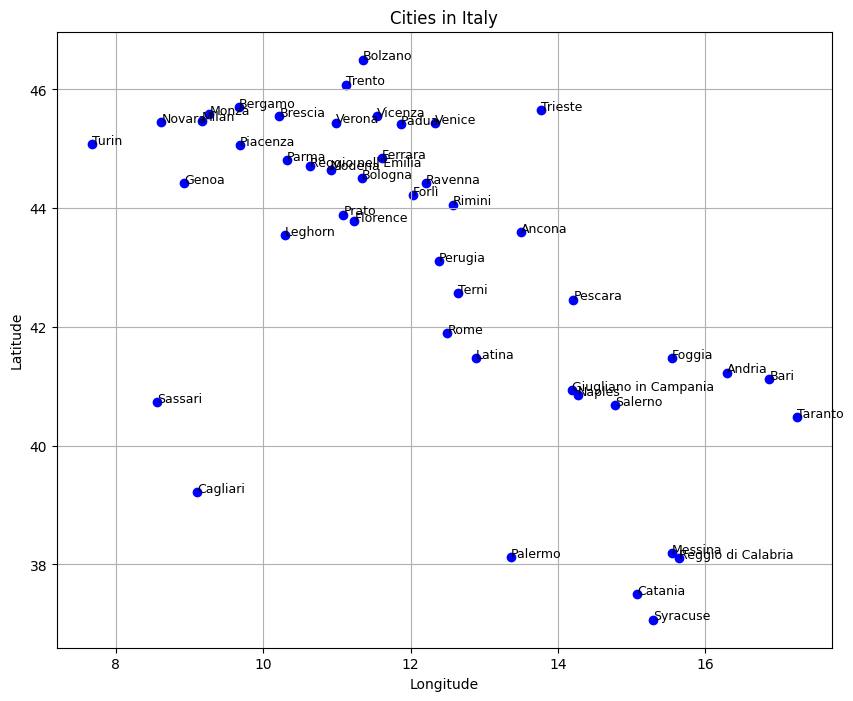

In [310]:
plt.figure(figsize=(10, 8))
plt.scatter(CITIES['lon'], CITIES['lat'], c='blue', marker='o')
for i, city in CITIES.iterrows():
    plt.text(city['lon'], city['lat'], city['name'], fontsize=9)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cities in Italy')
plt.grid(True)
plt.show()

# Utility

In [5]:
def valid(solution: NDArray[np.int32] | list[int]) -> bool:
    # TODO: check if 0 is a valid index
    if np.isin(solution, -1).any() or solution[0] != solution[-1]:
        return False
    return len(set(solution)) == len(CITIES)


def cost(solution: NDArray[np.int32] | list[int]) -> np.float64:
    if not isinstance(solution, (list, np.ndarray)) and len(solution) < 1:
        raise ValueError(f"Solution wrong type: {type(solution)}")
    cumulative_dist: np.float64 = np.float64(0)
    if not valid(solution):
        return np.float64(np.inf)
    for c1, c2 in zip(solution, solution[1:]):
        cumulative_dist += np.float64(DIST_MATRIX[c1, c2])
    return cumulative_dist


def mutation(individual: NDArray[np.int32], p_multiple_mutation: float = 0.3) -> NDArray[np.int32]:
    '''
    Perform a mutation on an individual's genome by moving a randomly selected subset of genes to a new position.
    # Parameters:
    individual (NDArray[np.int32]): The genome of the individual to mutate.
    p_multiple_mutation (float): Probability of multiple mutations (default is 0.3).
    # Returns:
    NDArray[np.int32]: The mutated genome.
    The mutation process involves:

        1. Selecting a random subset of genes from the genome.
        2. Creating a probability distribution for the new position of the selected subset.
        3. Moving the selected subset to the new position based on the probability distribution.
    '''
    high: int = len(individual) - 1
    mutated_genome: NDArray[np.int32] = individual.copy()

    # Select a random amount of cities
    while True:
        start: int = np.random.randint(1, high)
        end: int = np.random.randint(1, high)
        # Selecting at least 2 cities
        if end - start >= 1:
            break

    subset_length: int = end - start
    subset_to_move: NDArray[np.int32] = mutated_genome[start:end]

    # Create a probability distribution for the new position
    positions: NDArray[np.int32] = np.arange(1, high - subset_length)
    distances: NDArray[np.int32] = np.abs(positions - start)
    # Higher probability for nearby positions
    probabilities: NDArray[np.float64] = np.exp(-distances)
    # Normalize to sum to 1
    probabilities /= probabilities.sum()

    # Select a new position for the subset
    new_position: NDArray[np.int32] = np.random.choice(positions, p=probabilities)

    # Move the subset to the new position
    if new_position < start:
        mutated_genome = np.concatenate(
            (mutated_genome[:new_position], subset_to_move, mutated_genome[new_position:start], mutated_genome[end:])
        )
    else:
        mutated_genome = np.concatenate(
            (
                mutated_genome[:start],
                mutated_genome[end : new_position + subset_length],
                subset_to_move,
                mutated_genome[new_position + subset_length :],
            )
        )

    return mutated_genome


def get_elites_from_population(population: NDArray[np.int32], k: int = 2) -> NDArray[np.int32]:
    population_cost: NDArray[np.float64] = np.array([cost(individual) for individual in population])
    sorted_indices: NDArray[np.int32] = np.argsort(population_cost)

    sorted_population: NDArray[np.int32] = population[sorted_indices]
    return sorted_population[:k]


def xover(p1: NDArray[np.int32], p2: NDArray[np.int32], mutation_rate: float) -> NDArray[np.int32]:
    mask: NDArray[np.bool] = np.random.rand(p1.size) < 0.5
    # Choosing wrap-around city to be from parent 1 (parent 2 would work as well)
    mask[0] = mask[-1] = True
    child: NDArray[np.int32] = np.full(p1.size, -1, dtype=np.int32)
    child[mask] = p1[mask]
    for i in range(child.size):
        p2_idx = 0
        # when finding a not selected city in the child (value -1)
        # search for the first not already visited city from parent 2
        if child[i] == -1:
            for p2_idx in range(p2.size):
                if p2[p2_idx] in child:
                    continue
                child[i] = p2[p2_idx]
                break

    if np.random.rand() < mutation_rate:
        # logging.debug("Mutating...")
        child = mutation(child)

    # The mutation will always return a valid child, if not interrupt immediately and debug
    assert valid(
        child
    ), f"""
Invalid child: {child}
p1:            {p1}
p2:            {p2}
"""
    return child


def generate_random_combinations(num_individuals: int, num_combinations: int) -> NDArray[np.int32]:
    # Start from 1 to avoid division by zero
    values = np.arange(1, num_individuals + 1)

    # Assign higher probability to the lower value (fittest individual) and normalize the probabilities
    probabilities = 1 / values
    probabilities /= probabilities.sum()

    # Generate random combinations using the probability distribution
    random_combinations = np.random.choice(values, (num_combinations, 2), p=probabilities)

    # fix indexing starting with 0
    random_combinations = random_combinations - 1
    return random_combinations - 1

## Visual Utility

In [6]:
def save_solution(
    solution: list[int] | NDArray[np.int32],
    gen: int,
    algo_name: str,
    city_name: str,
    img_name_scheme: str = "gen",
    display: bool = False,
) -> None:
    # Multiplatform (Windows, Unix) handling of folders
    # double concatenate  e.g.
    # imgs,family_trip,italy -> imgs/family_trip italy -> imgs/family_trip/italy
    out_path: str = os.path.join(os.path.join(IMG_FOLDER, algo_name), city_name)
    # Assuming the notebook is run from the start and the folder is already sterilized
    create_folder(out_path)
    path_lons, path_lats = None, None
    if isinstance(solution, list):
        path_lons = [CITIES.iloc[city]['lon'] for city in solution]
        path_lats = [CITIES.iloc[city]['lat'] for city in solution]
    else:  # numpy array
        path_lons = [CITIES.iloc[city]['lon'] for city in solution]
        path_lats = [CITIES.iloc[city]['lat'] for city in solution]
    plt.figure(figsize=(10, 8))
    plt.scatter(CITIES['lon'], CITIES['lat'], c='blue', marker='o')
    for _, city in CITIES.iterrows():
        plt.text(city['lon'], city['lat'], city['name'], fontsize=9)
    plt.plot(path_lons, path_lats, c='blue', linestyle='-', linewidth=1, marker='o', markerfacecolor='red')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Best Travel Path - Generation {gen} - Path Len {cost(solution):.2f}km')
    plt.grid(True)
    # plt.savefig(f'{out_folder_name}/gen_{gen}.png')
    plt.savefig(os.path.join(out_path, f"{img_name_scheme}_{gen}.png"))
    if display:
        plt.show()
    plt.close()


def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)


def make_video(algo_name: str, city_name: str, video_name: str | None = None) -> None:
    # Multiplatform (Windows, Unix) handling of folders
    input_path: str = os.path.join(os.path.join(IMG_FOLDER, algo_name), city_name)
    if video_name is not None:
        out_file_path: str = os.path.join(OUTPUT_FOLDER, f"{video_name}.avi")
    else:
        out_file_path: str = os.path.join(OUTPUT_FOLDER, f"{city_name}.avi")

    images = [img for img in sorted_alphanumeric(os.listdir(input_path)) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(input_path, images[0]))
    height, width, _ = frame.shape

    video = cv2.VideoWriter(out_file_path, 0, 30, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(input_path, image)))

    cv2.destroyAllWindows()
    video.release()


def filter_generation_history(generation_history: NDArray[np.float64]) -> NDArray[np.int32]:
    # Filter out rows with more than three zeros
    valid_rows = np.array([row for row in generation_history if np.count_nonzero(row == 0) <= 3])
    return valid_rows


def plot_cost_history(cost_history: NDArray[np.float64]) -> None:
    # Accomodate algorithm find a early solution
    filtered_history = filter_generation_history(cost_history)

    plt.figure(figsize=(10, 6))
    plt.plot(filtered_history, label='Cost History')
    plt.xlabel('Generation')
    plt.ylabel('Cost')
    plt.title('Cost History Over Generations')
    plt.legend()
    plt.grid(True)

    # Increase resolution on the y-axis
    min_cost = filtered_history.min()
    max_cost = filtered_history.max()
    y_ticks = np.linspace(min_cost, max_cost, num=20)  # Adjust num for more or fewer ticks
    plt.yticks(y_ticks)

    # Increase resolution on the x-axis
    num_generations = len(filtered_history)
    x_ticks = np.linspace(0, num_generations - 1, num=20, dtype=int)  # Adjust num for more or fewer ticks
    plt.xticks(x_ticks)

    plt.show()

# Solution

## Family Trip

Starting:   0%|          | 0/100 [00:00<?, ?gen/s]

INFO: Generation 0: total length 14744.89km, valid: True
INFO: Generation 50: total length 6133.82km, valid: True
INFO: result: Found a path of 46 steps, total length 5269.84km, valid: True


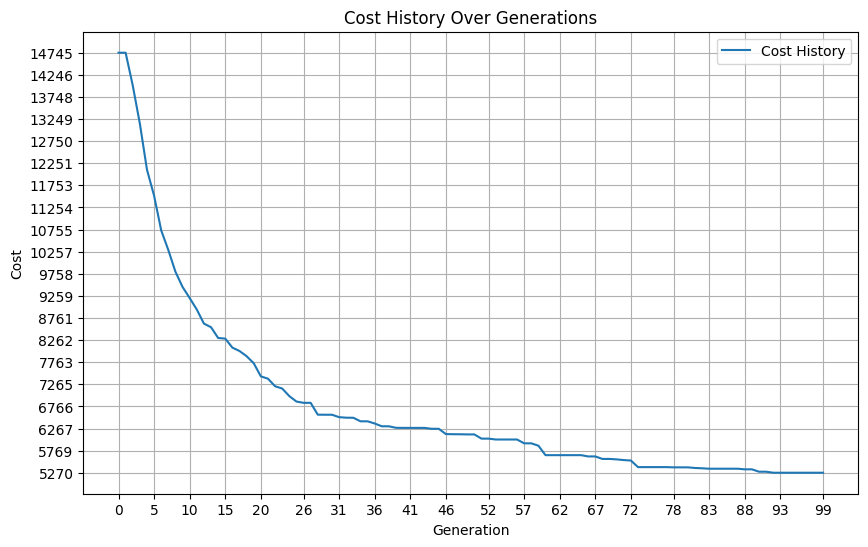

In [314]:
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)

POPULATION_SIZE = 250
MUTATION_RATE = 0.4
NUM_ELITES = 4

NUM_GENERATIONS = 100


population: NDArray[np.int32] = np.array([np.random.permutation(NUM_CITIES) for _ in range(POPULATION_SIZE)])
# considering one more cities for the circular path
best_evolution: NDArray[np.int32] = np.zeros((NUM_GENERATIONS, NUM_CITIES + 1), dtype=np.int32)
cost_history: NDArray[np.float64] = np.zeros(NUM_GENERATIONS, dtype=np.float64)

# append first city at the end to make the path circular
first_city: NDArray[np.int32] = population[:, 0].reshape(-1, 1)
population = np.hstack((population, first_city))

for solution in population:
    assert valid(solution), f"Invalid individual: {solution}"

# Initialize tqdm progress bar
progress_bar = tqdm(range(NUM_GENERATIONS), desc="Starting", unit="gen")

for gen in progress_bar:
    best_evolution[gen] = population[np.argmin([cost(individual) for individual in population])]
    cost_history[gen] = cost(best_evolution[gen])

    if cost_history[gen] - CITIES_SOLUTION[CITY_NAME] < 0.01:
        logging.info(
            f"SOLUTION FOUND!: Generation {gen}: total length {cost_history[gen]:.2f}km, valid: {valid(best_evolution[gen])}"
        )
        break
    if gen % 50 == 0:
        logging.info(f"Generation {gen}: total length {cost_history[gen]:.2f}km, valid: {valid(best_evolution[gen])}")
    progress_bar.set_description(f"Gen {gen} Best Cost: {cost_history[gen]:.2f}km")

    elites: NDArray[np.int32] = get_elites_from_population(population, NUM_ELITES)
    random_elites_combinations: NDArray[np.int32] = generate_random_combinations(NUM_ELITES, POPULATION_SIZE)
    # Recreate population for the fittest
    for n in range(POPULATION_SIZE):
        i1, i2 = random_elites_combinations[n]
        # crossover from two parent and reshape the output into a row as it will be appended
        child: NDArray[np.int32] = xover(elites[i1], elites[i2], MUTATION_RATE).reshape(1, -1)
        population = np.append(population, child, axis=0)
    # TODO: consider allocating population as POPULATION_SIZE + NUM_ELITES/2 * NUM_GENERATIONS
    population = population[-POPULATION_SIZE:].copy()

best_traveler: NDArray[np.int32] = population[np.argmin([cost(individual) for individual in population])]
logging.info(
    f"result: Found a path of {len(best_traveler)-1} steps, total length {cost(best_traveler):.2f}km, valid: {valid(best_traveler)}"
)
plot_cost_history(cost_history)

### Generating Video of the evolution

To generate the video firstly a snapshot of the fittest for the best individual is taken through the generations, then the snapshot are concatenated at 30fps (30 generations per seconds) to showcase the population evolving


In [8]:
algo_name = "family_trip"

logging.info("Saving the evolution...")
Parallel(n_jobs=int(cpu_count()), prefer='processes')(
    delayed(save_solution)(solution=best_evolution[gen], gen=gen, algo_name=algo_name, city_name=CITY_NAME)
    for gen in tqdm(range(NUM_GENERATIONS))
)

logging.info("Rendering Video...")
make_video(algo_name=algo_name, city_name=CITY_NAME)
logging.info("Done!")

  0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'best_evolution' is not defined

## Greedy Professor

In [280]:
visited = np.full(len(CITIES), False)
dist = DIST_MATRIX.copy()
city = 0
visited[city] = True
tsp: list[int] = list()
tsp.append(int(city))
gen = 0
while not np.all(visited):
    dist[:, city] = np.inf
    closest = np.argmin(dist[city])
    visited[closest] = True
    city = closest
    tsp.append(int(city))
    save_solution(tsp, gen, algo_name="prof", city_name=CITY_NAME)
    gen += 1
# Run when the while finishes (same as making all with indentation 0)
else:
    tsp.append(tsp[0])
    save_solution(tsp, gen, algo_name="prof", city_name=CITY_NAME)

# logging.debug(f"step: {CITIES.at[tsp[-1],'name']} -> {CITIES.at[tsp[0],'name']} ({DIST_MATRIX[tsp[-1],tsp[0]]:.2f}km)")

logging.info(f"result: Found a path of {len(tsp)-1} steps, total length {cost(tsp):.2f}km")
make_video(algo_name="prof", city_name=CITY_NAME, video_name=f"{CITY_NAME}_prof")

INFO: result: Found a path of 46 steps, total length 4436.03km
